# Imports, styles, etc

In [1]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy

import scipy.stats as stats

import sys
sys.path.append('../utils/')
from data import *
from liwc import *
from analisys import *

In [2]:
plt.rcParams['axes.labelsize']  = 10 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 2

In [3]:
plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

# Reading and processing data

In [4]:
def liwc_sentence_parse(s,liwc):
    return liwc.parse(s.split(' '))

def get_key_counts(counter,key):
    if key in counter:
        return counter[key]
    else:
        return 0

LIWC_FILEPATH = '../data/LIWC2015_English_Flat.dic'
liwc = Liwc(LIWC_FILEPATH)

df = get_movies_dataset()
df['liwc_count'] = df['text_clean'].apply(liwc_sentence_parse, args=(liwc,))
df['bad_words_count'] = df['tags_count'].apply(get_key_counts,args=(' __ ',))
df = df[df.bad_words_count==0]
df = df.drop(columns = ['tags_count','bad_words_count'])

In [5]:
scores = pd.DataFrame()
for file in os.listdir('../data/03_scored/with_curse_words'):
    tmp = pd.read_csv('../data/03_scored/with_curse_words/'+file)
    tmp['id']=file
    scores = scores.append(tmp, ignore_index=True)
scores['len'] = scores.text.str.split(' ').str.len()

total_score = (scores.groupby('id')['score'].sum()/scores.groupby('id')['len'].sum()).sort_values()[::-1]

In [6]:
df = df.set_index('id')
df['score'] = total_score
df = df.reset_index()
df = df[df.score.notna()]

In [7]:
d = get_movies_dataset()
d['bad_words_count'] = d['tags_count'].apply(get_key_counts,args=(' __ ',))
d

,movie,age,group,has-en-sub,url,id,text,text_clean,tags_count,bad_words_count
0,Black Panther,2018,White Man,0,https://www.youtube.com/watch?v=A_yiL6YB7LE&ab...,A_yiL6YB7LE,I saw black panther and if I looked stoned out...,I saw black panther and if I looked stoned out...,{'Music': 2},0
1,Black Panther,2018,White Man,0,https://www.youtube.com/watch?v=7Usr96nwjqI&ab...,7Usr96nwjqI,Black Panther was directed by Ryan Coogler and...,Black Panther was directed by Ryan Coogler and...,"{' __ ': 1, 'Music': 1}",1
2,Black Panther,2018,White Man,0,https://www.youtube.com/watch?v=BQtPELpog1o&ab...,BQtPELpog1o,[Music] either guys how are you so let's talk ...,either guys how are you so let's talk about B...,{'Music': 3},0
3,Black Panther,2018,Black Man,0,https://www.youtube.com/watch?v=Wc0pK98d65Q&ab...,Wc0pK98d65Q,this movie started up so well and crashed and ...,this movie started up so well and crashed and ...,{},0
4,Black Panther,2018,Black Man,0,https://www.youtube.com/watch?v=UVwBpHknNzY&ab...,UVwBpHknNzY,[Music] well Conda forever what is happening m...,well Conda forever what is happening magnesit...,"{'Music': 3, ' __ ': 7}",7
...,...,...,...,...,...,...,...,...,...,...
630,Logan,2017,White Woman,0,https://www.youtube.com/watch?v=csbRjP3GyhQ&ab...,csbRjP3GyhQ,[Music] hi and welcome to residues today i'm g...,hi and welcome to residues today i'm going to...,{'Music': 2},0
631,Logan,2017,Black Man,0,https://www.youtube.com/watch?v=LZqhBeEdGZk&ab...,LZqhBeEdGZk,one last time [Music] hey guys the last critic...,one last time hey guys the last critic guy in...,"{'Music': 4, 'Applause': 1}",0
632,Logan,2017,Black Man,0,https://www.youtube.com/watch?v=gJDctCOOhsQ&ab...,gJDctCOOhsQ,watch it bub welcome to the Kaiba she oh yes f...,watch it bub welcome to the Kaiba she oh yes f...,{},0
633,Logan,2017,Black Man,0,https://www.youtube.com/watch?v=wmWStFQp0t0&ab...,wmWStFQp0t0,hello and welcome to the flick advisory today ...,hello and welcome to the flick advisory today ...,{'Music': 1},0


In [8]:
d[d.bad_words_count==0].groupby('group').count()

,movie,age,has-en-sub,url,id,text,text_clean,tags_count,bad_words_count
group,,,,,,,,,
Black Man,82,82,82,82,82,82,82,82,82
Black Woman,42,42,42,42,42,42,42,42,42
White Man,267,267,267,267,267,267,267,267,267
White Woman,162,162,162,162,162,162,162,162,162


---

# Toxic phrases exemples

In [9]:
phrases = scores.merge(df[['movie','age','group','id']],on='id')

In [10]:
phrases.iloc[[31463,30591,38070,34814]][['text','score','movie','group']]

,text,score,movie,group
31463,he became an ultra hard ass because he got his...,0.892803,Casablanca,White Woman
30591,today is just how damn funny it is from scene ...,0.949928,Modern Times,White Man
38070,in paris who fell in love and yeah and that su...,0.860626,Casablanca,Black Woman
34814,also getting rocked in the head because I was ...,0.901780,Coco,Black Man


In [11]:
# print(scores.iloc[[31463,30591,38070,34814]][['text','score','movie','group']].to_latex(index=False,))

---

# Processing data with LIWC

In [12]:
#LIWC data

LIWC_FILEPATH = '../data/LIWC2015_English_Flat.dic'
liwc = Liwc(LIWC_FILEPATH)

liwc_df = pd.DataFrame().from_records(df['liwc_count'],index=df['id'])
liwc_df = liwc_df.fillna(0)

#normalizing 
#Normalizando pelo numero de categorias obtidas ????????????????? qual a melhor forma de fazer isso? talvez pelo numero de palavras
liwc_df_norm = (liwc_df[liwc.categories.values()].T * ( 1 / liwc_df[liwc.categories.values()].sum(axis=1) )).T

liwc_df_norm.reset_index(inplace=True)
liwc_df_norm['group'] = df['group']
liwc_df_norm['age'] = df['age']

---

## Kruscal-Wallis Test

In [13]:
experiments = []

for feature in liwc.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='White Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='White Woman'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Woman'][feature],
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0] ,
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [14]:
experiments[experiments['pvalue']<0.02].sort_values('pvalue')

,feature,statistic,pvalue
20,quant,45.429640,7.498099e-10
67,informal,38.059231,2.746028e-08
59,space,37.242565,4.088498e-08
15,verb,37.131304,4.316250e-08
69,netspeak,32.476639,4.152565e-07
57,relativ,32.394058,4.322421e-07
9,article,32.313947,4.493822e-07
13,conj,31.979148,5.286691e-07
19,number,31.956363,5.345469e-07
70,assent,31.594096,6.372621e-07


## Black people use more informalities

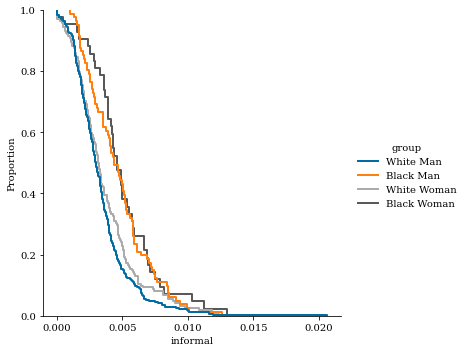

In [15]:
sns.displot(liwc_df_norm, x="informal", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.savefig('informal.pdf')

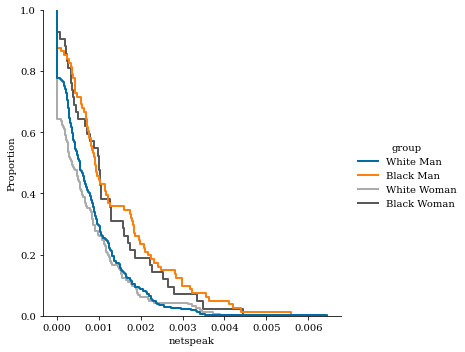

In [16]:
sns.displot(liwc_df_norm, x="netspeak", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.savefig('netspeak.pdf')

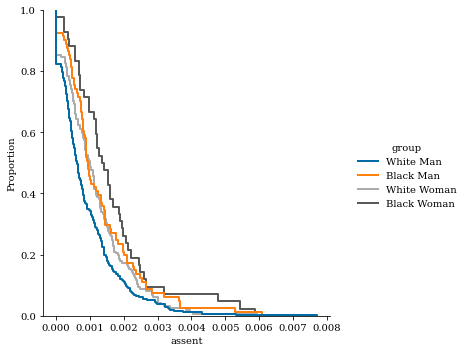

In [17]:
sns.displot(liwc_df_norm, x="assent", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc

## Others stats 

### swear - fuck, damn, shit

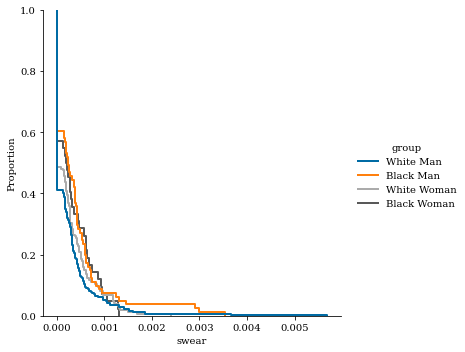

In [18]:
sns.displot(liwc_df_norm, x="swear", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc

### prep - prepositions - to, with, above 

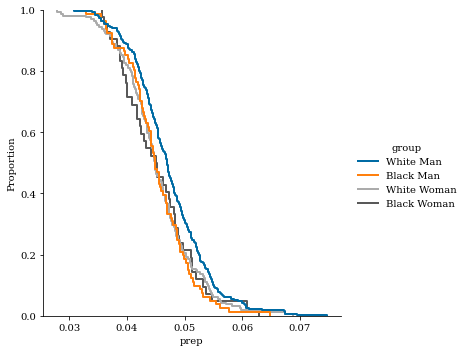

In [19]:
sns.displot(liwc_df_norm, x="prep", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc

### anx - worried, fearful

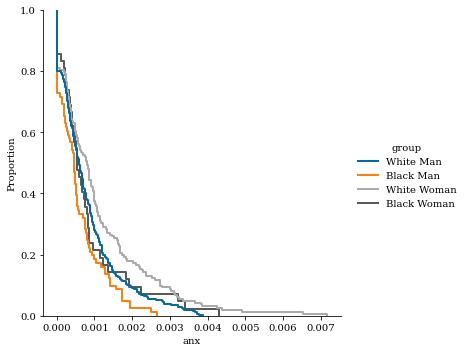

In [20]:
sns.displot(liwc_df_norm, x="anx", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc

### percept - Perceptual processes - look, heard, feeling 

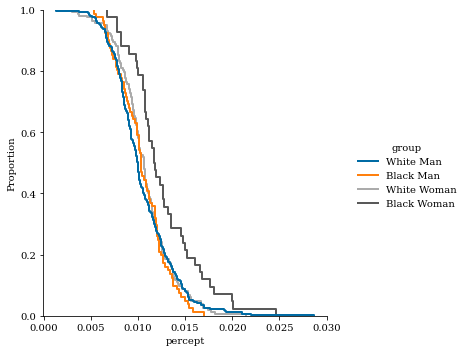

In [21]:
sns.displot(liwc_df_norm, x="percept", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc

### conj - Conjunctions - and, but, whereas

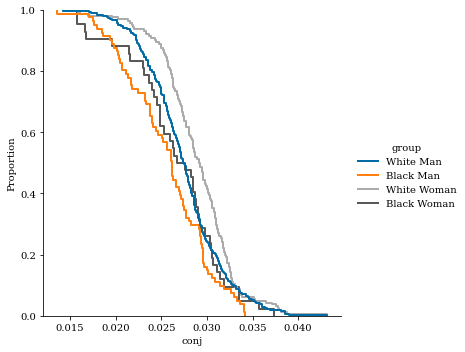

In [22]:
sns.displot(liwc_df_norm, x="conj", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc

---

# Diferences between groups on toxicity score

### Kruskal-wallis test

In [23]:
result = stats.kruskal(
        df[df.group=='White Man']['score'],
        df[df.group=='White Woman']['score'],
        df[df.group=='Black Man']['score'],
        df[df.group=='Black Woman']['score'],
    )
result

KruskalResult(statistic=44.46854994219302, pvalue=1.2000517887413716e-09)

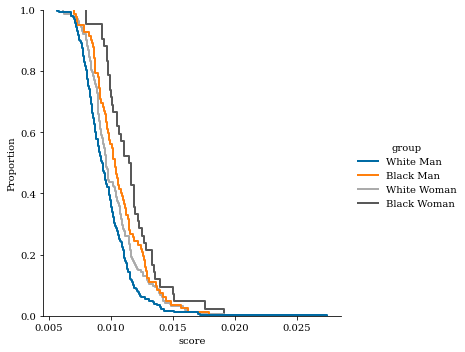

In [24]:
sns.displot(df, x="score", hue="group", kind="ecdf",complementary=True) #checar o que sao adjetivos

---

# Bad Words

In [25]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})
bad_words = word_scores[word_scores.score>0.2]

In [26]:
def get_word_count(text, word):
    text_s = pd.Series(text.split(' '))
    return (text_s==word).sum()

def get_bad_words_count(text, bad_words):
    total=0
    for bad_word in bad_words:
        total +=get_word_count(text,bad_word)
    return total

In [27]:
df['bad_words_count'] = df['text_clean'].apply(get_bad_words_count,args=(bad_words.words,)) 

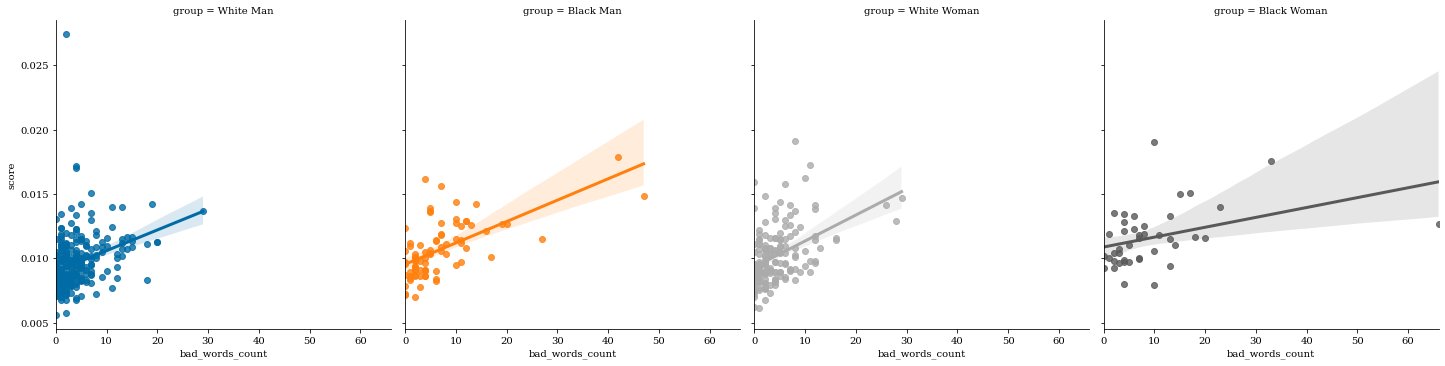

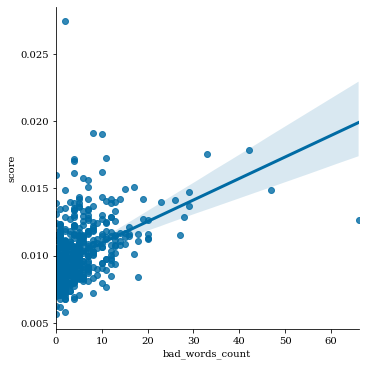

In [28]:
display(sns.lmplot(col="group", hue="group", data=df,x='bad_words_count',y='score'))
display(sns.lmplot(data=df,x='bad_words_count',y='score'))

## Person correlation

In [29]:
print('For all data:', scipy.stats.pearsonr(df.bad_words_count,df.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.pearsonr(df[df.group==group].bad_words_count, df[df.group==group].score))

For all data: (0.4371831564608414, 3.584353788758878e-27)
For White Man: (0.3236539715431537, 6.67099635063735e-08)
For Black Man: (0.6129967319543519, 9.270491831281517e-10)
For White Woman: (0.44261040504189375, 3.693387860319182e-09)
For Black Woman: (0.38107464042882144, 0.012779260631408522)


## Spearman correlation

In [30]:
print('For all data:', scipy.stats.spearmanr(df.bad_words_count,df.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.spearmanr(df[df.group==group].bad_words_count, df[df.group==group].score))

For all data: SpearmanrResult(correlation=0.48409018744394844, pvalue=8.98408374120283e-34)
For White Man: SpearmanrResult(correlation=0.40250952789606553, pvalue=8.813268843811482e-12)
For Black Man: SpearmanrResult(correlation=0.6410051184077327, pvalue=8.766158158598437e-11)
For White Woman: SpearmanrResult(correlation=0.4462414951494484, pvalue=2.656683449081681e-09)
For Black Woman: SpearmanrResult(correlation=0.4480311738360811, pvalue=0.0029258761721907213)


### Kruskal-Wallis on bad words count

In [27]:
result = stats.kruskal(
        df[df.group=='White Man']['bad_words_count'],
        df[df.group=='White Woman']['bad_words_count'],
        df[df.group=='Black Man']['bad_words_count'],
        df[df.group=='Black Woman']['bad_words_count'],
    )
result

KruskalResult(statistic=30.156924159386772, pvalue=1.2790442093808033e-06)

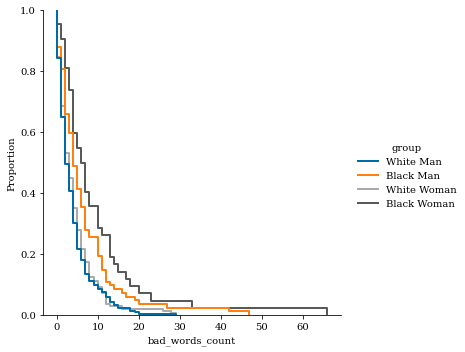

In [28]:
sns.displot(df, x="bad_words_count", hue="group", kind="ecdf",complementary=True) #checar o que sao adjetivos

---

# Words relation - bad words

In [30]:
bad_words = word_scores[word_scores.score>0.2]

bad_words = bad_words.set_index('words')
bad_words['White Man'] = np.nan
bad_words['Black Man'] = np.nan
bad_words['White Woman'] = np.nan
bad_words['Black Woman'] = np.nan

for bad_word in tqdm(bad_words.index):
    for group in df.group.unique():
        total = 0
        for sent in df[df.group==group].text_clean:
             total += get_word_count(sent,bad_word)
        bad_words.loc[bad_word,group] = total
            
# bad_words = bad_words.reset_index()

100%|██████████| 842/842 [03:55<00:00,  3.58it/s]


In [65]:
display(bad_words['White Man'].sort_values(ascending=False).head(20))
display(bad_words['White Woman'].sort_values(ascending=False).head(20))
display(bad_words['Black Man'].sort_values(ascending=False).head(20))
display(bad_words['Black Woman'].sort_values(ascending=False).head(20))

words
black       120.0
death        74.0
dead         47.0
fire         46.0
murder       42.0
die          38.0
damn         32.0
violence     31.0
hell         28.0
killing      26.0
kill         22.0
executed     20.0
cancer       19.0
shoot        17.0
enemy        17.0
ass          17.0
killed       17.0
sex          17.0
sexual       16.0
shooting     16.0
Name: White Man, dtype: float64

words
black       92.0
death       41.0
dead        41.0
die         28.0
murder      26.0
violence    21.0
fire        19.0
died        16.0
killed      16.0
mad         15.0
kill        15.0
stupid      15.0
sexual      13.0
damn        13.0
sick        12.0
ass         12.0
shoot       12.0
hell        12.0
sex         11.0
kills       10.0
Name: White Woman, dtype: float64

words
black       112.0
kill         43.0
dope         33.0
hell         29.0
dead         27.0
killed       24.0
fire         16.0
crap         13.0
die          12.0
sick         12.0
death        11.0
mad           9.0
killing       9.0
damn          9.0
shooting      8.0
sex           8.0
pissed        7.0
ass           7.0
burn          7.0
gay           6.0
Name: Black Man, dtype: float64

words
black       137.0
dead         17.0
gay          16.0
kill         16.0
damn         12.0
death        10.0
hell          8.0
killed        8.0
cancer        8.0
murder        7.0
fire          7.0
violence      7.0
mad           7.0
sick          6.0
sexual        6.0
suicide       6.0
dumb          5.0
stupid        5.0
racist        5.0
kills         4.0
Name: Black Woman, dtype: float64

### Word: dope - Black Man

In [32]:
before,after = get_word_relations('dope', df[df['group']=="Black Man"].text_clean)

In [33]:
display(before,after)

,word,count
0,it's,1
1,just,2
2,is,5
3,still,1
4,a,4
5,really,3
6,pretty,2
7,this,1
8,much,1
9,and,1


,word,count
0,that,2
1,to,5
2,one,1
3,but,1
4,now,1
5,little,2
6,as,1
7,the,3
8,character,1
9,Joe,1


### Word: damn - Black Woman

In [34]:
a,b = get_word_relations('damn', df[df['group']=="Black Woman"].text_clean)

In [35]:
display(a,b)

,word,count
0,the,3
1,a,4
2,like,2
3,Mississippi,1
4,personality,1
5,my,1


,word,count
0,thing,3
1,way,1
2,but,1
3,the,1
4,heart,1
5,soundtrack,1
6,i'm,1
7,nerves,1
8,if,2


### Word: gay - Black Woman

In [36]:
a,b = get_word_relations('gay', df[df['group']=="Black Woman"].text_clean)

In [37]:
display(a,b)

,word,count
0,for,1
1,make,1
2,a,3
3,closeted,3
4,he's,2
5,be,1
6,black,2
7,about,1
8,young,1
9,and,1


,word,count
0,people,2
1,man,2
2,Mian,1
3,men,4
4,he's,1
5,oh,1
6,character,1
7,black,2
8,and,1
9,I,1


### Word: extra

In [81]:
a,b = get_word_relations('hella', df.text_clean)

In [82]:
display(a,b)

,word,count
0,while,1
1,in,1
2,also,1
3,evil,1
4,Asgard,1
5,even,1
6,with,4
7,about,2
8,as,5
9,plays,1


,word,count
0,the,4
1,played,1
2,well,1
3,invades,1
4,his,1
5,and,3
6,it,2
7,who,2
8,who's,1
9,is,3


---

# Words relation - informal - LIWC

In [38]:
informal = pd.DataFrame()
informal['White Man'] = np.nan
informal['Black Man'] = np.nan
informal['White Woman'] = np.nan
informal['Black Woman'] = np.nan

In [39]:
for i,data in df.iterrows():
    for word in data.text_clean.split(' '):
        liwc_val = liwc.parse([word])['informal']
        if liwc_val>0:
            if word not in informal.index:
                informal.loc[word,data.group] = liwc_val
            else:
                informal.loc[word,data.group] += liwc_val
informal = informal.fillna(0)

In [40]:
informal.idxmax()

White Man      well
Black Man      okay
White Woman    cool
Black Woman     yes
dtype: object

In [41]:
#We need to computete each informal word toxicity value to compare who much toxicity is added by this words

---

# Looking for correlations in the data

### Top k = 20

In [47]:
topk = df.sort_values('score',ascending = False).groupby('group').head(20)

In [48]:
_vars = ['swear','social','informal','netspeak','anx','adj','quant','filler']

for var in _vars:
    topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))

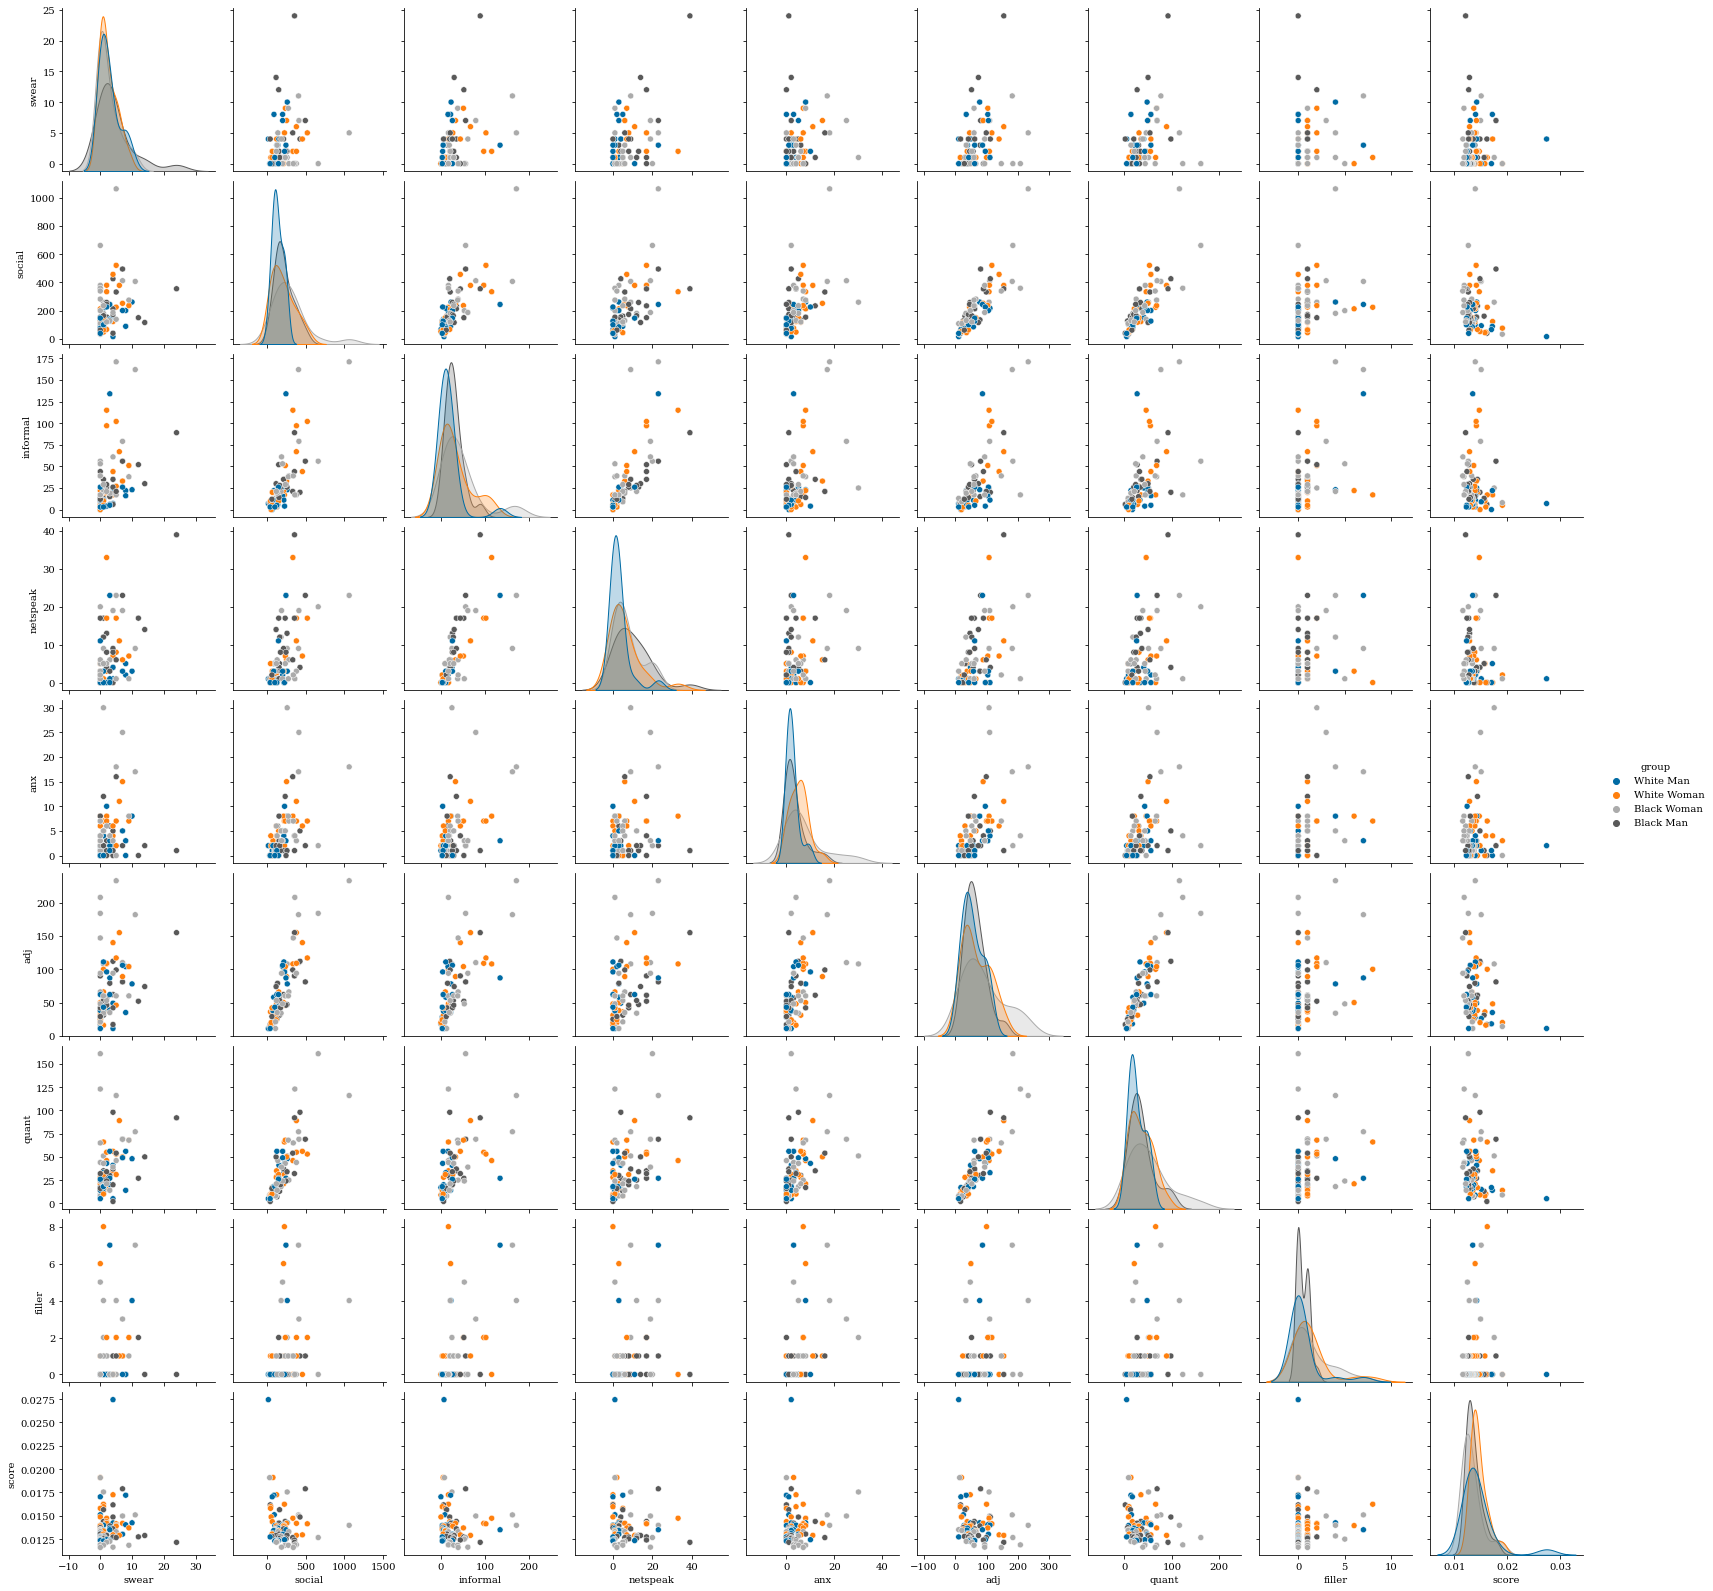

In [51]:
sns.pairplot(topk[_vars+['score','group']], hue='group')

### Person correlation

In [61]:
print('For all data:', scipy.stats.spearmanr(topk.bad_words_count,topk.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.spearmanr(topk[topk.group==group].bad_words_count, topk[topk.group==group].score))

For all data: SpearmanrResult(correlation=0.04678830731924593, pvalue=0.6802464840230872)
For White Man: SpearmanrResult(correlation=0.28561425672505864, pvalue=0.2222039591722281)
For Black Man: SpearmanrResult(correlation=-0.0822647366680636, pvalue=0.7302481437455091)
For White Woman: SpearmanrResult(correlation=0.01886091593505513, pvalue=0.9370930763853151)
For Black Woman: SpearmanrResult(correlation=0.13413749425416666, pvalue=0.5728811329496438)


In [92]:
bad_words = word_scores[word_scores.score>0.2]

bad_words = bad_words.set_index('words')
bad_words['White Man'] = np.nan
bad_words['Black Man'] = np.nan
bad_words['White Woman'] = np.nan
bad_words['Black Woman'] = np.nan

for bad_word in tqdm(bad_words.index):
    for group in df.group.unique():
        total = 0
        for sent in df[df.group==group].text_clean:
             total += get_word_count(sent,bad_word)
        bad_words.loc[bad_word,group] = total
            

,age,has-en-sub,score,bad_words_count
group,,,,
Black Man,165077,0,0.873104,544
Black Woman,84420,2,0.487571,395
White Man,531017,11,2.559781,1028
White Woman,324973,7,1.653298,693


In [96]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})
# bad_words = word_scores[word_scores.score>0.2]

In [118]:
word_scores = []

,words,score
0,abbo,0.085628
1,abo,0.075186
2,abortion,0.443301
3,abuse,0.249865
4,addict,0.272337
...,...,...
1345,xxx,0.173277
1346,yankee,0.073303
1347,yellowman,0.114010
1348,zigabo,0.069039


In [135]:
l = []
df['has_bad_word'] = False
for word in tqdm(word_scores[word_scores.score>0.8].words):
    df['has_bad_word'] |= df.text_clean.str.contains(word)
    print(word, df.text_clean.str.contains(word).sum())
    

  2%|▏         | 6/280 [00:00<00:05, 52.47it/s]

anal 34
analannie 0
analsex 0
anus 2
arse 3
arsehole 0
ass 359
assbagger 0
assblaster 0
assclown 0
asscowboy 0
asses 47


  7%|▋         | 19/280 [00:00<00:04, 56.09it/s]

assfuck 0
assfucker 0
asshat 1
asshole 0
assholes 0
asshore 0
assjockey 0
asskiss 0
asskisser 0
asslick 0
asslicker 0
asslover 0
assmonkey 0


 12%|█▎        | 35/280 [00:00<00:03, 64.83it/s]

asspacker 0
asspirate 0
assranger 0
asswhore 0
badfuck 0
bastard 5
biatch 0
bitch 2
bitcher 0
bitches 0
bitchez 0
bitchin 2
bitching 2
bitchslap 0
bitchy 0
blowjob 0
boobs 0
bullshit 0
bumblefuck 0
bumfuck 0
buttfuck 0


 20%|██        | 57/280 [00:00<00:02, 79.55it/s]

butt-fuck 0
buttfucker 0
butt-fucker 0
buttfuckers 0
butt-fuckers 0
chink 0
cock 37
cockblock 0
cockblocker 0
cockcowboy 0
cockhead 0
cocklicker 0
cockqueen 0
cocksmoker 0
cocksucer 0
cocksuck 0
cocksucked 0
cocksucker 0
cocksucking 0
crack-whore 0


 28%|██▊       | 77/280 [00:00<00:02, 86.52it/s]

crap 25
cumming 0
cunt 0
cuntfuck 0
cuntfucker 0
cuntlick 0
cuntlicker 0
cuntlicking 0
cuntsucker 0
dammit 2
damnit 1
datnigga 0
dick 5
dickbrain 0
dickhead 0
dicklick 0
dicklicker 0
dickwad 0


 34%|███▍      | 95/280 [00:01<00:02, 79.66it/s]

dumb 21
dumbass 0
dumbbitch 0
dumbfuck 0
eatpussy 0
ejaculate 0
erection 1
facefucker 0
fag 0
fagging 0
faggot 0
fagot 0
fannyfucker 0
fastfuck 0
fatass 0
fatfuck 0
fatfucker 0


 40%|████      | 113/280 [00:01<00:02, 79.41it/s]

fckcum 0
fingerfuck 0
fingerfucker 0
fingerfuckers 0
fingerfucking 0
fistfuck 0
fistfucked 0
fistfucker 0
fistfucking 0
footfuck 0
footfucker 0
freakfuck 0
freakyfucker 0
freefuck 0
fuck 2
fucka 0
fuckable 0


 46%|████▋     | 130/280 [00:01<00:02, 74.20it/s]

fuckbag 0
fuckbuddy 0
fucked 1
fuckedup 0
fucker 0
fuckers 0
fuckface 0
fuckfest 0
fuckfreak 0
fuckfriend 0
fuckhead 0
fuckher 0
fuckin 1
fucking 1
fuckingbitch 0


 52%|█████▏    | 146/280 [00:01<00:01, 69.37it/s]

fuckinnuts 0
fuckinright 0
fuckit 0
fuckknob 0
fuckme 0
fuckmonkey 0
fuckoff 0
fuckpig 0
fucks 0
fucktard 0
fuckwhore 0
fuckyou 0
fuk 0
fuks 0
funfuck 0
fuuck 0
gaymuthafuckinwhore 0


 58%|█████▊    | 163/280 [00:02<00:01, 67.54it/s]

gaysex 0
goddamit 0
goddamn 9
goddamned 0
goddamnes 0
goddamnit 1
goddamnmuthafucker 0
gook 0
headfuck 0
hiscock 0
hooker 1
hookers 0
horseshit 0
hotpussy 0


 63%|██████▎   | 177/280 [00:02<00:01, 62.83it/s]

idiot 9
jackass 0
jerkoff 0
kike 0
kill 143
loser 29
masturbate 0
masturbating 1
moron 1
mothafuck 0
mothafucka 0
mothafuckaz 0
mothafucked 0
mothafucker 0


 68%|██████▊   | 191/280 [00:02<00:01, 61.99it/s]

mothafuckin 0
mothafucking 0
mothafuckings 0
motherfuck 0
motherfucked 0
motherfucker 0
motherfuckin 0
motherfucking 0
motherfuckings 0
nastybitch 0
nastywhore 0
niger 0
nigga 0
niggarded 0


 71%|███████   | 198/280 [00:02<00:01, 57.50it/s]

niggardliness 0
niggardliness's 0
niggards 0
niggaz 0
nigger 0
niggerhead 0
niggerhole 0
niggers 0
nigger's 0
nofuckingway 0
nutfucker 0


 76%|███████▌  | 212/280 [00:02<00:01, 59.10it/s]

penile 0
penis 1
penises 0
poorwhitetrash 0
prostitute 0
pussies 0
pussy 0
pussyeater 0
pussyfucker 0
pussylicker 0
pussylips 0
pussylover 0
pussypounder 0
rapist 1


 80%|████████  | 225/280 [00:03<00:01, 51.48it/s]

rentafuck 0
scum 1
semen 6
sexwhore 0
shagging 0
shit 14
shitcan 0
shitdick 0
shite 0
shiteater 0


 85%|████████▍ | 237/280 [00:03<00:00, 50.04it/s]

shitface 0
shitfaced 0
shitfit 0
shitforbrains 0
shitfuck 0
shitfucker 0
shitfull 0
shithead 0
shiting 0
shitlist 0
shits 1


 89%|████████▉ | 249/280 [00:03<00:00, 51.00it/s]

shitstain 0
shitter 0
shitting 0
shitty 7
shortfuck 0
sissy 0
skankbitch 0
skankfuck 0
skankybitch 0
slut 1
sluts 0
slutty 0


 93%|█████████▎| 261/280 [00:03<00:00, 49.45it/s]

slutwear 0
slutwhore 0
spermbag 0
spic 24
spick 0
stupid 32
stupidfuck 0
stupidfucker 0
suck 61
suckdick 0
sucker 5


 97%|█████████▋| 271/280 [00:04<00:00, 47.03it/s]

suckmyass 0
suckmydick 0
timbernigger 0
titfuck 0
titfucker 0
titfuckin 0
tits 0
titties 0
twat 0
uck 219
vagina 0
vaginal 0
wank

100%|██████████| 280/280 [00:04<00:00, 64.55it/s]

 0
wanker 0
wanking 0
wetback 0
whore 0
whorefucker 0
whorehouse 0


In [131]:
df.groupby('group').sum()

,age,has-en-sub,score,bad_words_count,has_bad_word
group,,,,,
Black Man,165077,0,0.873104,544,69
Black Woman,84420,2,0.487571,395,35
White Man,531017,11,2.559781,1028,230
White Woman,324973,7,1.653298,693,130


In [132]:
df.groupby('group').count()

,id,movie,age,has-en-sub,url,text,text_clean,liwc_count,score,bad_words_count,has_bad_word
group,,,,,,,,,,,
Black Man,82,82,82,82,82,82,82,82,82,82,82
Black Woman,42,42,42,42,42,42,42,42,42,42,42
White Man,266,266,266,266,266,266,266,266,266,266,266
White Woman,162,162,162,162,162,162,162,162,162,162,162


### Word: gay - Black Woman

In [36]:
a,b = get_word_relations('gay', df[df['group']=="Black Woman"].text_clean)

In [37]:
display(a,b)

,word,count
0,for,1
1,make,1
2,a,3
3,closeted,3
4,he's,2
5,be,1
6,black,2
7,about,1
8,young,1
9,and,1


,word,count
0,people,2
1,man,2
2,Mian,1
3,men,4
4,he's,1
5,oh,1
6,character,1
7,black,2
8,and,1
9,I,1


In [111]:
l

[0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 548    False
 549    False
 550    False
 551    False
 552    False
 Name: text_clean, Length: 552, dtype: bool,
 0      True
 1      True
 2      True
 3      True
 4      True
        ... 
 548    True
 549    True
 550    True
 551    True
 552    True
 Name: text_clean, Length: 552, dtype: bool,
 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 548    False
 549    False
 550    False
 551    False
 552    False
 Name: text_clean, Length: 552, dtype: bool,
 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 548    False
 549    False
 550    False
 551    False
 552    False
 Name: text_clean, Length: 552, dtype: bool,
 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 548    False
 549    False
 550    False
 551    False
 552    False
 Name: text_clean, Length: 552, dtype: bool,
 0      False
 1

In [43]:
display(get_word_relations('ass',topk[topk.group=='Black Woman'].text_clean))
print()
display(get_word_relations('ass',topk[topk.group=='White Man'].text_clean))

(   word  count
 0  kick      1
 1    an      1,
   word  count
 0  and      1
 1  but      1)

(      word  count
 0  shopped      1
 1      her      1
 2       my      2
 3    funny      1
 4  kicking      1,
     word  count
 0     it      1
 1    and      2
 2  let's      1
 3   when      1
 4  movie      1)

In [44]:
display(get_word_relations('black',topk[topk.group=='Black Woman'].text_clean))
print()
display(get_word_relations('black',topk[topk.group=='White Man'].text_clean))

(                word  count
 0              about      2
 1              black      1
 2                for      2
 3                 of      3
 4         protesting      1
 ..               ...    ...
 61             brown      1
 62      specifically      1
 63         murderous      1
 64  african-american      1
 65               his      1
 
 [66 rows x 2 columns],
           word  count
 0        black      1
 1   population      3
 2       people     25
 3          guy      3
 4         Pete      1
 ..         ...    ...
 58   Americans      1
 59        side      1
 60    whatever      1
 61           a      1
 62      father      1
 
 [63 rows x 2 columns])

(       word  count
 0        me      2
 1    people      1
 2       her      1
 3      wild      1
 4        so      1
 5         a      6
 6      lush      1
 7       saw      1
 8       the      3
 9     being      1
 10      and      2
 11    enjoy      1
 12     have      1
 13     film      4
 14  panther      1
 15    movie      1
 16     wear      1,
       word  count
 0      and      3
 1   people      1
 2   friend      1
 3   comedy      1
 4    woman      1
 5  panther     19
 6       in      1
 7       on      1
 8  on\nthe      1)

---

In [45]:
var = 'informal'
topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

KeyError: "['informal'] not in index"

---

/home/luiznery/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:301: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
/home/luiznery/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:304: RuntimeWarning: divide by zero encountered in log
  _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
/home/luiznery/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:301: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
/home/luiznery/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:304: RuntimeWarning: divide by zero encountered in log
  _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
/home/luiznery/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:301: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
/home/luiznery/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:304: RuntimeWarning: divide by zero encountere

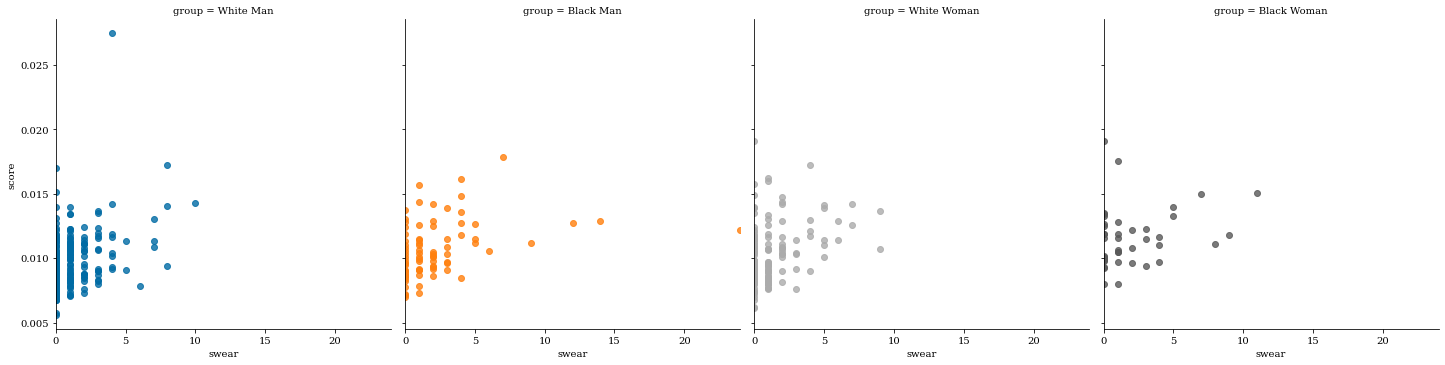

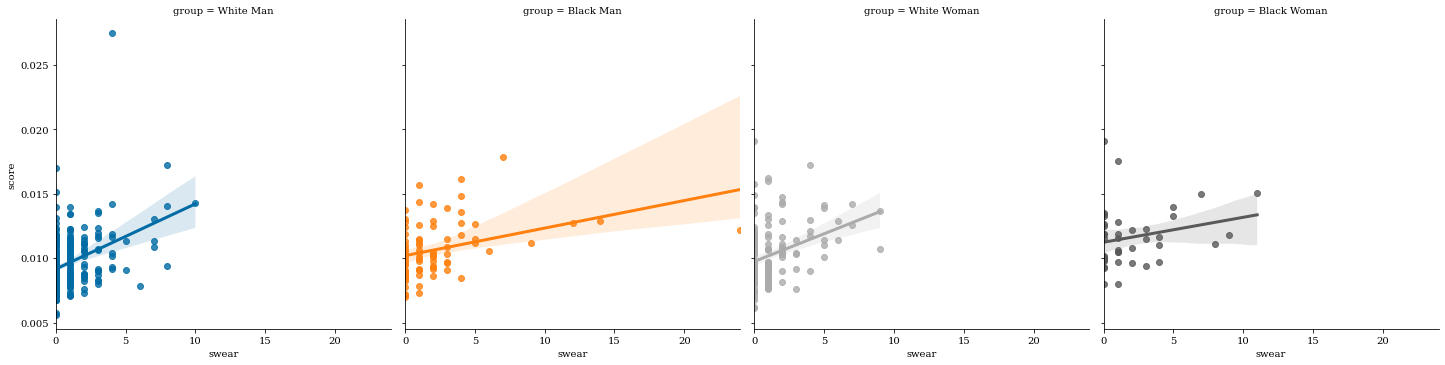

In [187]:
var = 'swear'
topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

df[var] = df.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

---

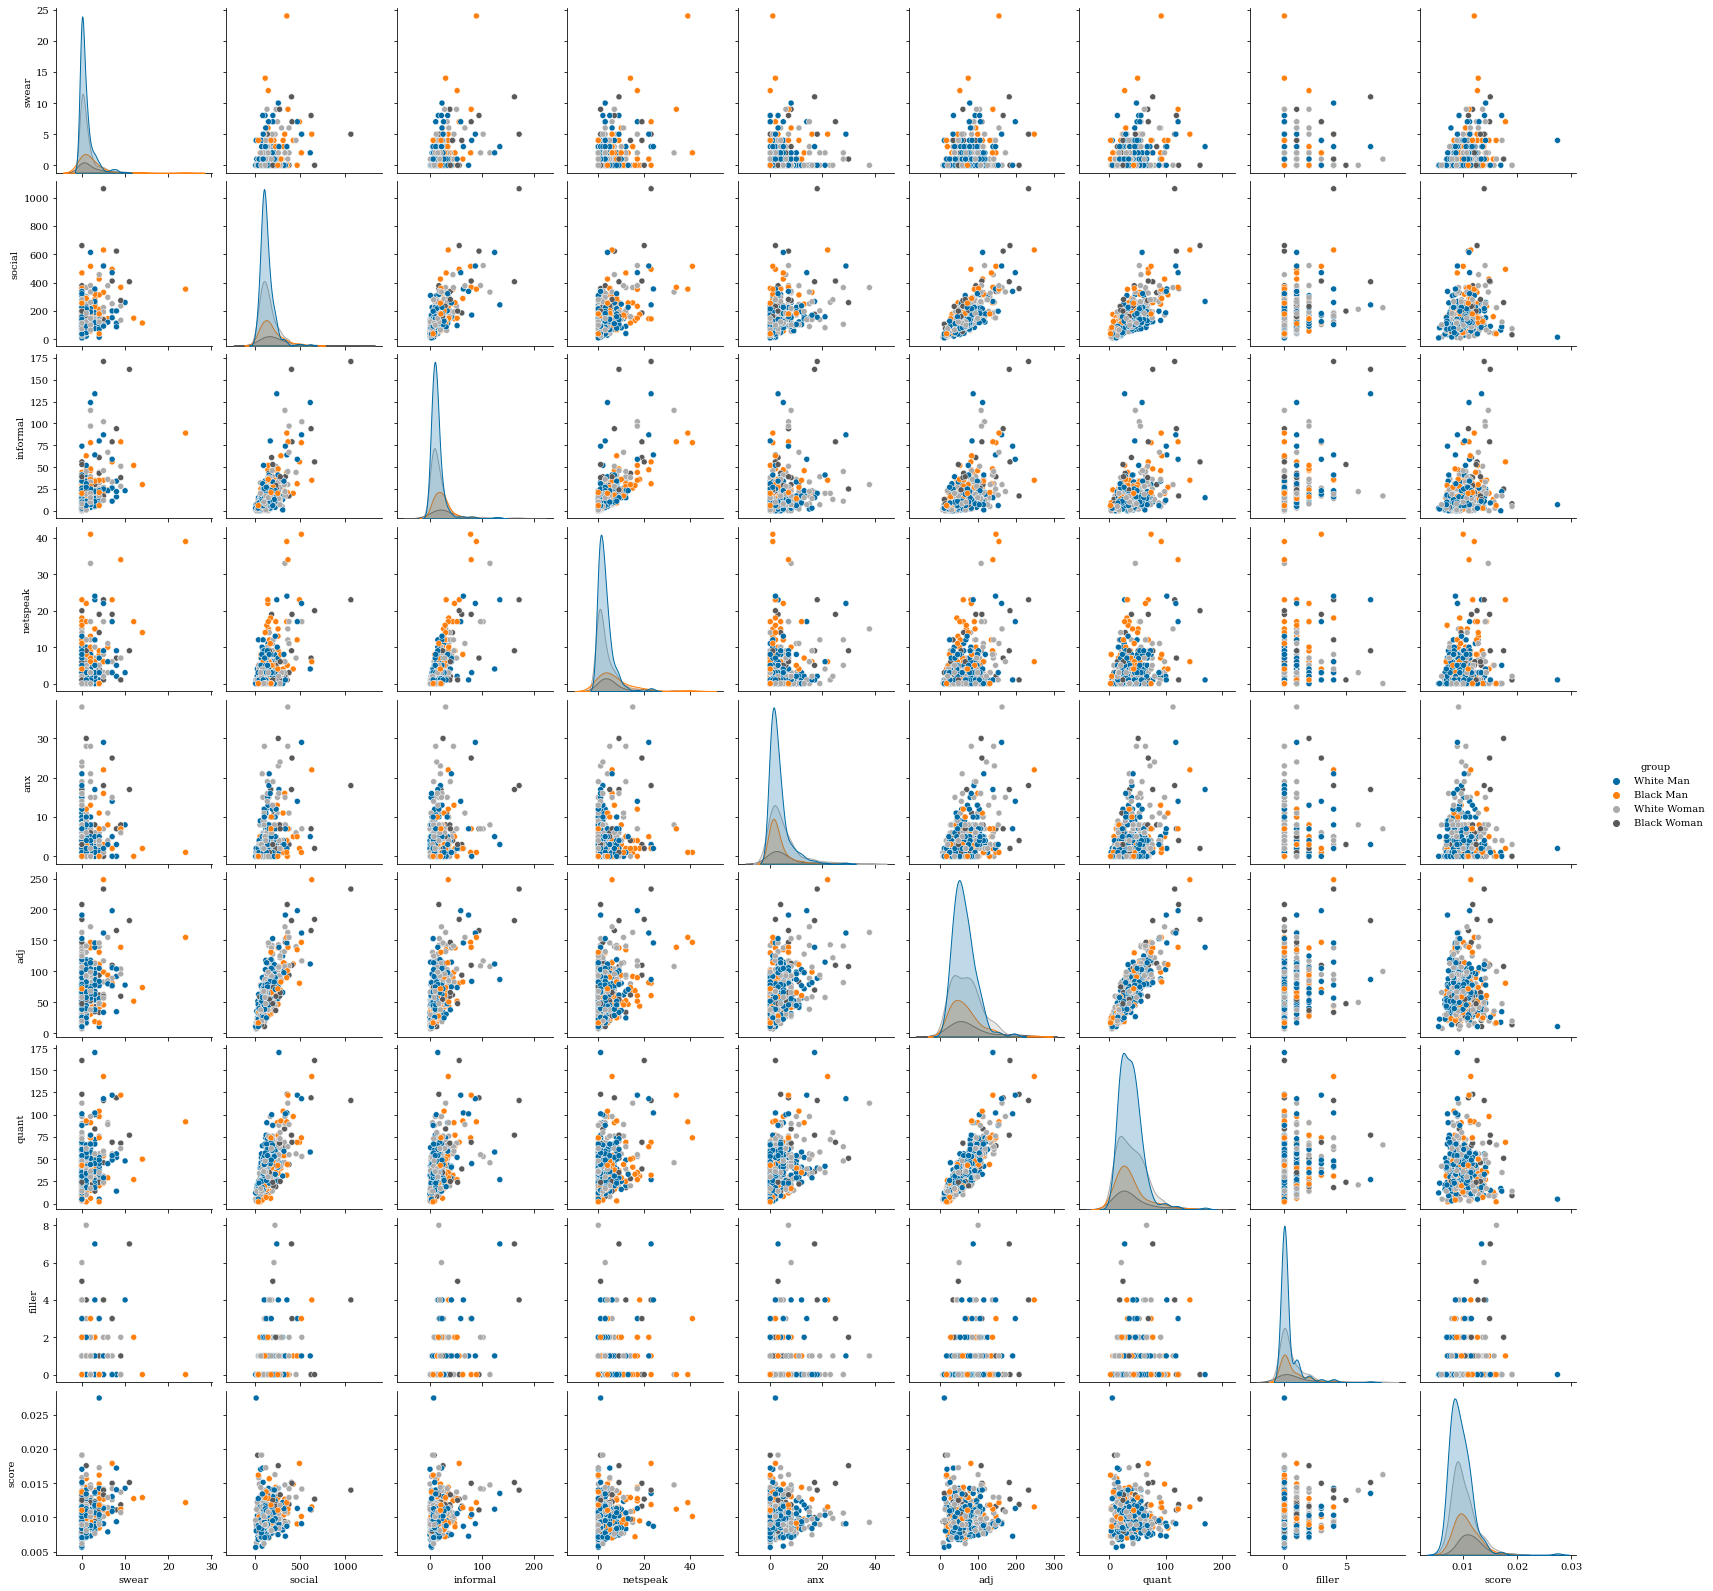

In [183]:
experiments[experiments['pvalue']<0.02].sort_values('pvalue')

,feature,statistic,pvalue
20,quant,45.429640,7.498099e-10
67,informal,38.059231,2.746028e-08
59,space,37.242565,4.088498e-08
15,verb,37.131304,4.316250e-08
69,netspeak,32.476639,4.152565e-07
57,relativ,32.394058,4.322421e-07
9,article,32.313947,4.493822e-07
13,conj,31.979148,5.286691e-07
19,number,31.956363,5.345469e-07
70,assent,31.594096,6.372621e-07
